In [1]:
#Import Packages 
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import wrf 
import glob 
from scipy.interpolate import RegularGridInterpolator, interp1d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pathlib import Path
import random

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
#Create Path For Data Collection and Create A List of File Names
prestorm_data_path = '/storage/group/pmm116/default/pmm116/predictability_study-30sec-output/prestorm16/'
file_paths = glob.glob(prestorm_data_path + "*00*.nc")
filenames = sorted([Path(path).name for path in file_paths if path.endswith(".nc")])

#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
prestorm_data = xr.open_dataset(prestorm_data_path + filenames[0])

#Dataset Domain Size
ni = prestorm_data['ni']
nj = prestorm_data['nj']
nk = prestorm_data['nk']

#Datapoint Locations
x_data = prestorm_data['xh']*units.kilometer
y_data = prestorm_data['yh']*units.kilometer
z_data = prestorm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = prestorm_data['xf']*units.kilometer
y_grid = prestorm_data['yf']*units.kilometer
z_grid = prestorm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values + 12.5).argmin()-2
upper_bound_x = np.abs(x_data.values - 12.5).argmin()
lower_bound_y = np.abs(y_data.values + 12.5).argmin()
upper_bound_y = np.abs(y_data.values - 12.5).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(0,len(filenames),1):
    t = xr.open_dataset(prestorm_data_path + filenames[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0] #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon

# Box & Whisker Plots and Correlation Matrix: PseudoData

In [3]:
#Load The pseudo_data

path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Data/'
pseudo_data = np.load(path+'pseudodata_2_cm1grid.npz')
points_data = np.load(path+'instantaneous_data.npz')


#Data Interpolated to Model Grid
P = pseudo_data['P']
T = pseudo_data['T']
Th = pseudo_data['Th']
Td = pseudo_data['Td']
qv = pseudo_data['qv']
u = pseudo_data['u']
v = pseudo_data['v']
w = pseudo_data['w']
zvort = pseudo_data['zvort']
parc_T = pseudo_data['parc_T']
CAPE = pseudo_data['CAPE']
CIN = pseudo_data['CIN']
SRH1km = pseudo_data['SRH1km']
SRH3km = pseudo_data['SRH3km']

#Original Trajectory Points
# points = pseudo_data['interp_points']

#Ground Relative Winds
offset_u = 12.2 
offset_v = 12.5 
gr_u = u[0] + offset_u
gr_v = v[0] + offset_v
gr_wind = np.sqrt((gr_u**2)+(gr_v**2)) 

Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

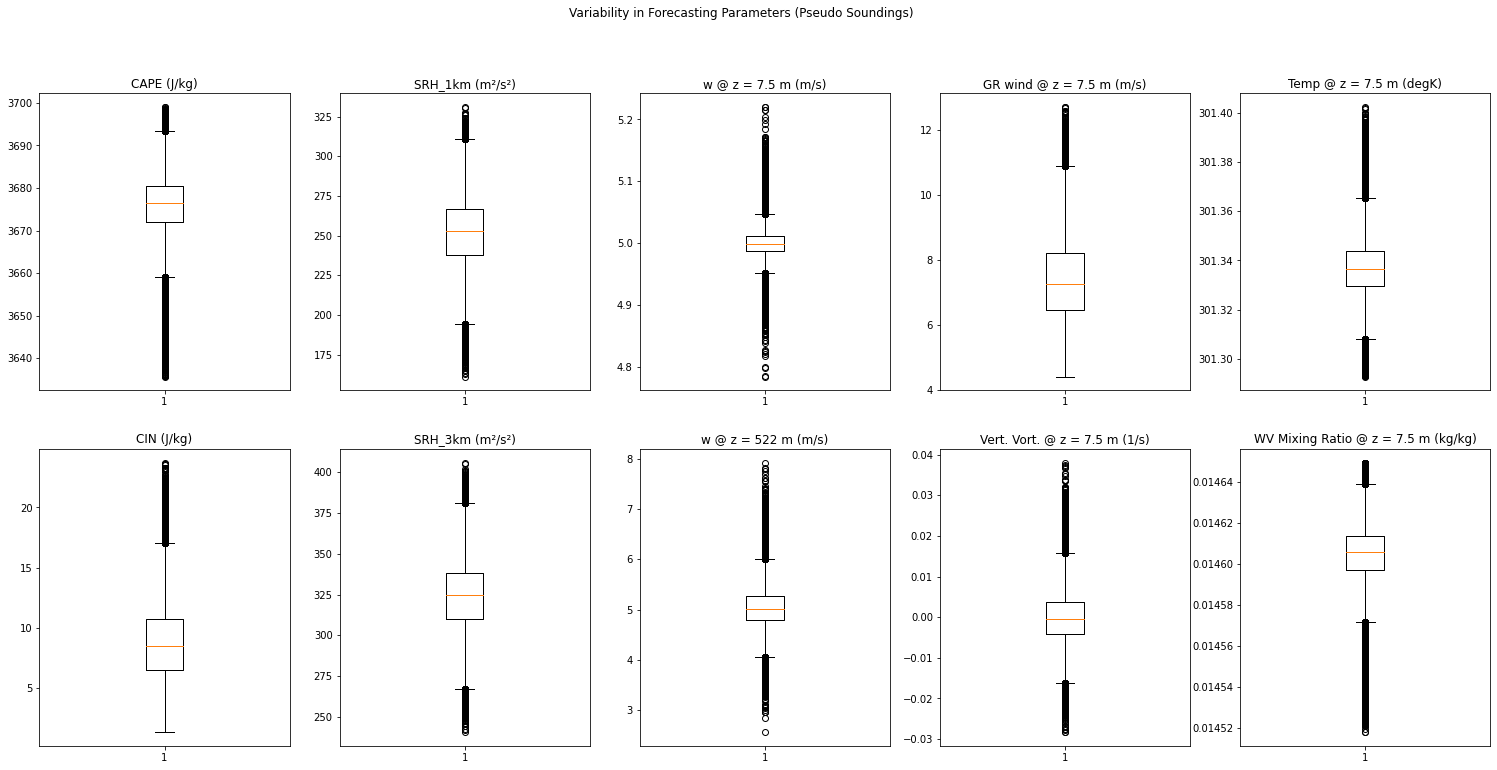

In [4]:
#Create A Figure With All Boxplots with Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Pseudo Soundings)')

#CAPE 
axs[0,0].boxplot(CAPE[0])
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(CIN[0])
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(SRH1km)
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(SRH3km)
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(w[0])
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(w[17])
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(gr_wind)
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(zvort[0])
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(T[0])
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(qv[0])
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

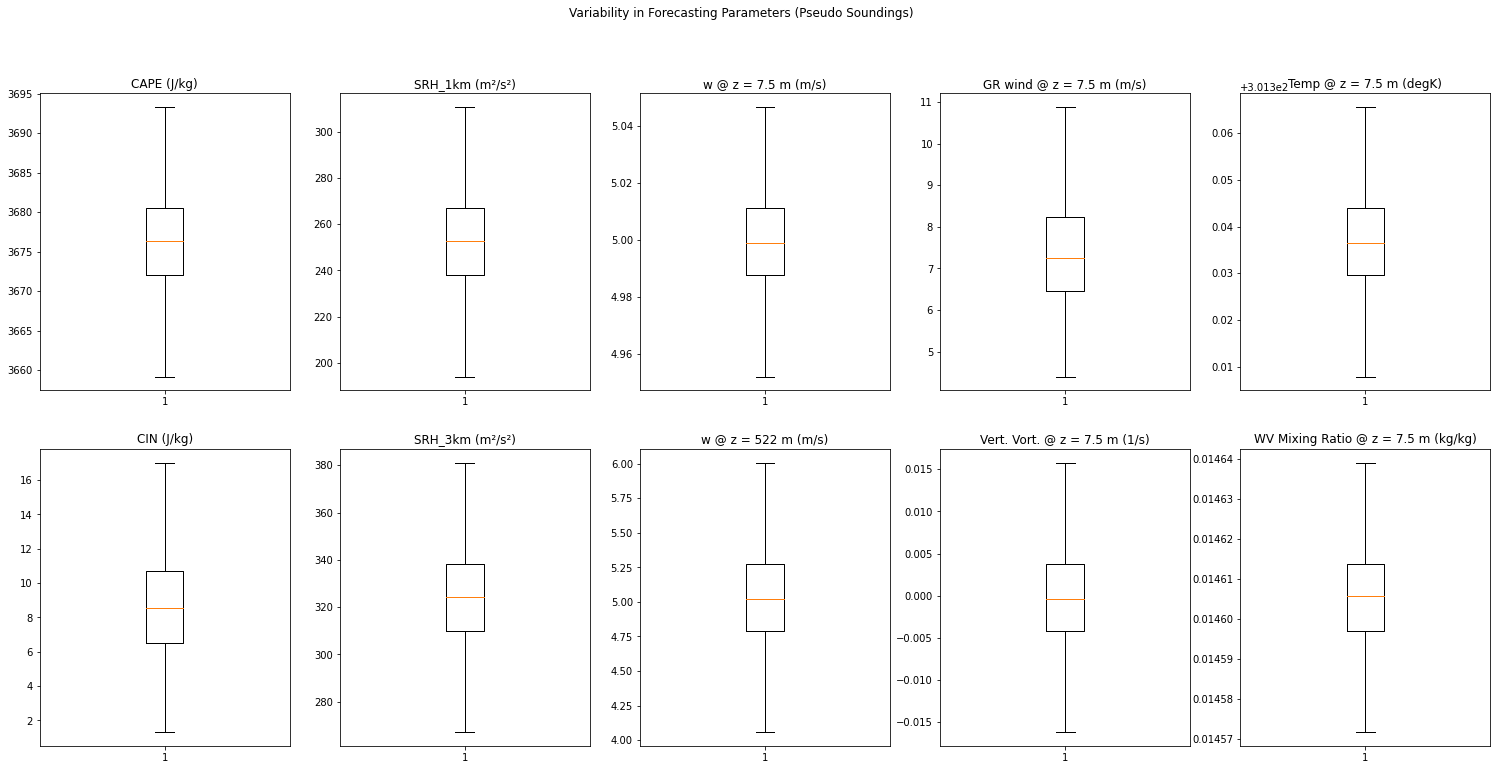

In [7]:
#Create A Figure With All Boxplots without Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Pseudo Soundings)')

#CAPE 
axs[0,0].boxplot(CAPE[0],0,'')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(CIN[0],0,'')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(SRH1km,0,'')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(SRH3km,0,'')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(w[0],0,'')
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(w[17],0,'')
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(gr_wind,0,'')
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(zvort[0],0,'')
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(T[0],0,'')
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(qv[0],0,'')
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')




In [8]:
#Create Correlation Matrix

#Assemble the Data
data = {
    'CAPE':CAPE[0],
    'CIN':CIN[0],
    'SRH1km':SRH1km,
    'SRH3km':SRH3km,
    'w_75':w[0],
    'w_522':w[17],
    'gr_wind':gr_wind,
    'zvort':zvort[0],
    'T':T[0],
    'qv':qv[0]
}

dataframe = pd.DataFrame(data, columns=['CAPE','CIN','SRH1km','SRH3km','w_75','w_522','gr_wind','zvort','T','qv'])

#Create the Matrix
matrix = dataframe.corr()
matrix

,CAPE,CIN,SRH1km,SRH3km,w_75,w_522,gr_wind,zvort,T,qv
CAPE,1.000000,-0.033415,0.167153,0.159547,0.000003,0.023073,-0.235547,-0.066990,-0.856117,0.897984
CIN,-0.033415,1.000000,0.162724,-0.150232,-0.021010,-0.239343,-0.060620,-0.005621,-0.050407,0.064337
SRH1km,0.167153,0.162724,1.000000,0.909132,0.280781,-0.015540,-0.726921,-0.014746,-0.102782,0.154113
SRH3km,0.159547,-0.150232,0.909132,1.000000,0.292785,0.066781,-0.724323,-0.009947,-0.085662,0.122064
w_75,0.000003,-0.021010,0.280781,0.292785,1.000000,0.112279,-0.415577,0.197688,0.015381,-0.010925
w_522,0.023073,-0.239343,-0.015540,0.066781,0.112279,1.000000,-0.081885,-0.004352,-0.030194,0.024505
gr_wind,-0.235547,-0.060620,-0.726921,-0.724323,-0.415577,-0.081885,1.000000,0.027970,0.134235,-0.241351
zvort,-0.066990,-0.005621,-0.014746,-0.009947,0.197688,-0.004352,0.027970,1.000000,0.061388,-0.075750
T,-0.856117,-0.050407,-0.102782,-0.085662,0.015381,-0.030194,0.134235,0.061388,1.000000,-0.966432
qv,0.897984,0.064337,0.154113,0.122064,-0.010925,0.024505,-0.241351,-0.075750,-0.966432,1.000000


# Box & Whisker Plots and Correlation Matrix: Instantaneous Data

In [5]:
#Read Instantaneousinst_data

path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Data/'
inst_data = np.load(path+'instantaneous_data.npz')
points_data = np.load(path+'interpolation_2_rawtrajectories.npz')

inst_P = inst_data['P']
inst_T = inst_data['T']
inst_Td = inst_data['Td']
inst_Th = inst_data['Th']
inst_qv = inst_data['qv']
inst_u = inst_data['u']
inst_v = inst_data['v']
inst_w = inst_data['w']
inst_zvort = inst_data['zvort']
inst_parc_T = inst_data['parc_T']
inst_CAPE = inst_data['CAPE']
inst_CIN = inst_data['CIN']
inst_SRH1km = inst_data['SRH1km']
inst_SRH3km = inst_data['SRH3km']

#Original Trajectory Points
points = points_data['interp_points']

#Ground Relative Winds
offset_u = 12.2
offset_v = 12.5 
gr_u = inst_u[0]+offset_u
gr_v = inst_v[0]+offset_v
inst_gr_wind = np.sqrt((gr_u**2)+(gr_v**2))

Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

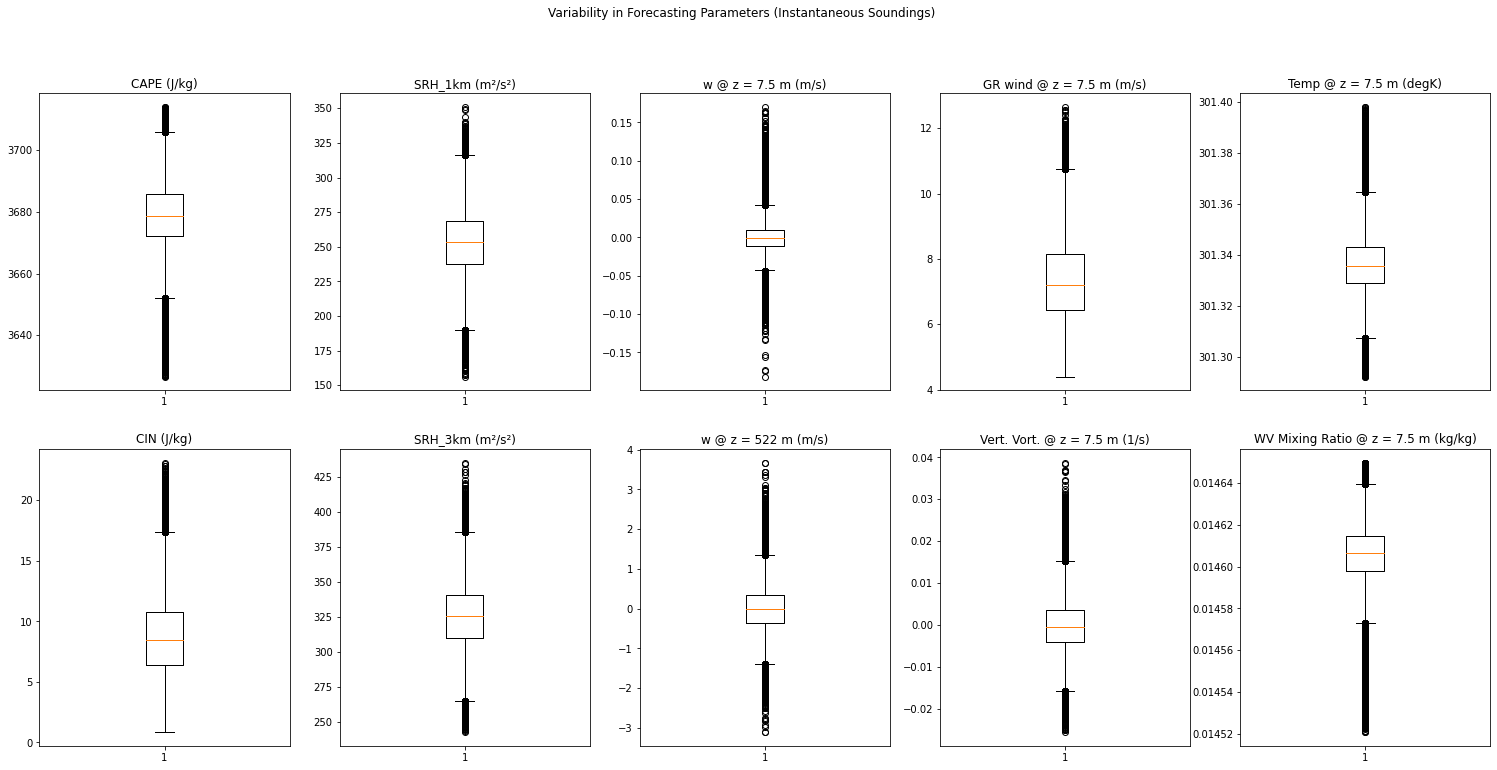

In [10]:
#Create A Figure With All Boxplots with Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Instantaneous Soundings)')


#CAPE 
axs[0,0].boxplot(inst_CAPE[0])
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(inst_CIN[0])
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(inst_SRH1km)
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(inst_SRH3km)
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(inst_w[0])
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(inst_w[17])
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(inst_gr_wind)
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(inst_zvort[0])
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(inst_T[0])
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(inst_qv[0])
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')


Text(0.5, 1.0, 'WV Mixing Ratio @ z = 7.5 m (kg/kg)')

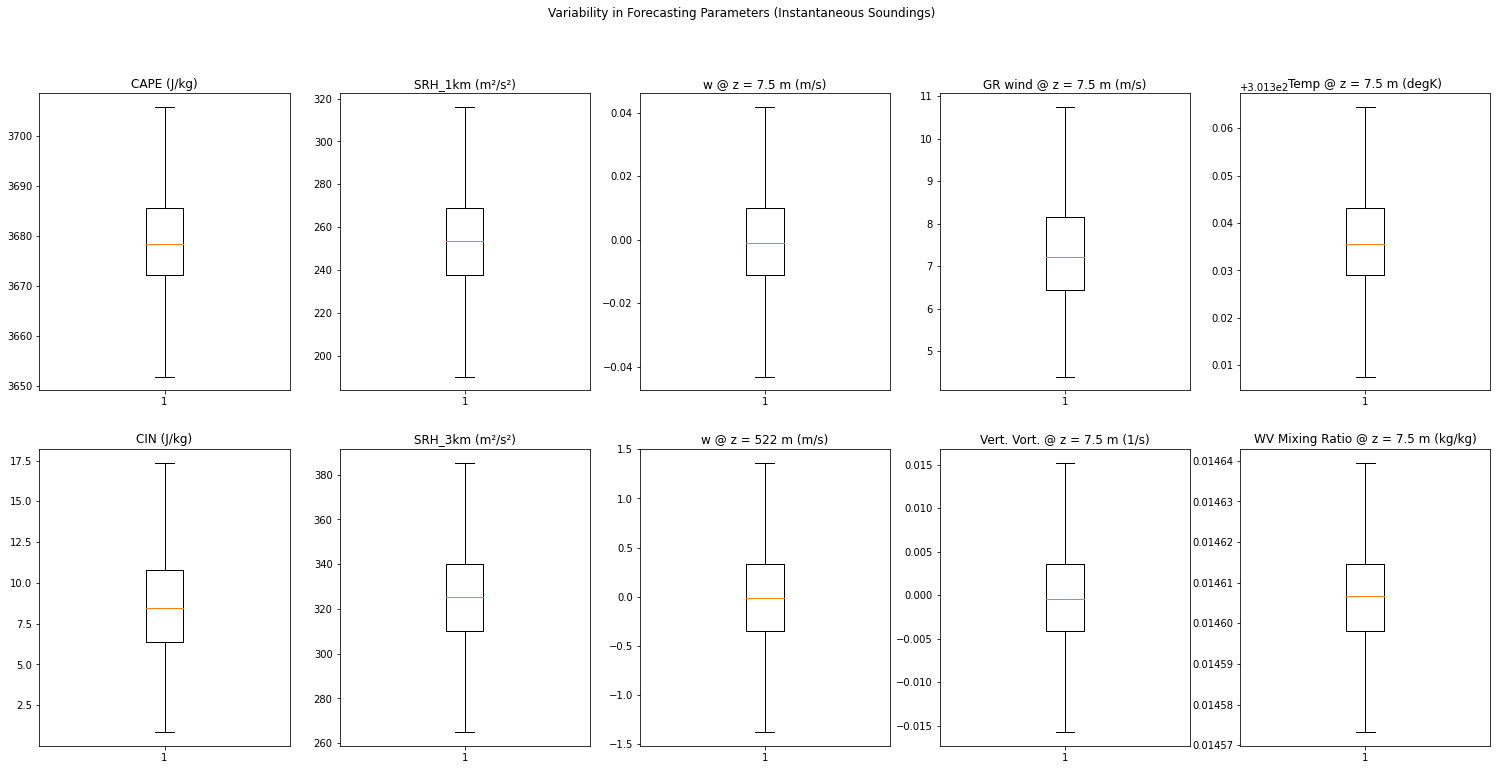

In [11]:
#Create A Figure With All Boxplots without Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (26,12))

fig.suptitle('Variability in Forecasting Parameters (Instantaneous Soundings)')

#CAPE 
axs[0,0].boxplot(inst_CAPE[0],0,'')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(inst_CIN[0],0,'')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(inst_SRH1km,0,'')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2)')

#SRH3km
axs[1,1].boxplot(inst_SRH3km,0,'')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w @ z = 7.5 m
axs[0,2].boxplot(inst_w[0],0,'')
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
axs[1,2].boxplot(inst_w[17],0,'')
axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
axs[0,3].boxplot(inst_gr_wind,0,'')
axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
axs[1,3].boxplot(inst_zvort[0],0,'')
axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
axs[0,4].boxplot(inst_T[0],0,'')
axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
axs[1,4].boxplot(inst_qv[0],0,'')
axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

In [12]:
#Create Correlation Matrix

#Assemble the Data
data = {
    'CAPE':inst_CAPE[0],
    'CIN':inst_CIN[0],
    'SRH1km':inst_SRH1km,
    'SRH3km':inst_SRH3km,
    'w_75':inst_w[0],
    'w_522':inst_w[17],
    'gr_wind':inst_gr_wind,
    'zvort':inst_zvort[0],
    'T':inst_T[0],
    'qv':inst_qv[0]
}

dataframe = pd.DataFrame(data, columns=['CAPE','CIN','SRH1km','SRH3km','w_75','w_522','gr_wind','zvort','T','qv'])

#Create the Matrix
matrix = dataframe.corr()

matrix

,CAPE,CIN,SRH1km,SRH3km,w_75,w_522,gr_wind,zvort,T,qv
CAPE,1.000000,-0.023988,0.011131,-0.013844,-0.003955,0.027331,-0.129054,-0.046189,-0.491535,0.528442
CIN,-0.023988,1.000000,0.158461,-0.180808,-0.024170,-0.160844,-0.037813,-0.020726,-0.017354,0.016320
SRH1km,0.011131,0.158461,1.000000,0.893598,0.317688,-0.047942,-0.629855,-0.012341,-0.102756,0.128172
SRH3km,-0.013844,-0.180808,0.893598,1.000000,0.327975,0.000362,-0.624525,-0.011948,-0.126093,0.137168
w_75,-0.003955,-0.024170,0.317688,0.327975,1.000000,0.108140,-0.414125,0.224580,0.021282,-0.018197
w_522,0.027331,-0.160844,-0.047942,0.000362,0.108140,1.000000,-0.060593,-0.012376,-0.019033,0.031876
gr_wind,-0.129054,-0.037813,-0.629855,-0.624525,-0.414125,-0.060593,1.000000,0.029267,0.118611,-0.230111
zvort,-0.046189,-0.020726,-0.012341,-0.011948,0.224580,-0.012376,0.029267,1.000000,0.060936,-0.078248
T,-0.491535,-0.017354,-0.102756,-0.126093,0.021282,-0.019033,0.118611,0.060936,1.000000,-0.964815
qv,0.528442,0.016320,0.128172,0.137168,-0.018197,0.031876,-0.230111,-0.078248,-0.964815,1.000000


# Now Combine Pseudo and Instantaneous 

In [6]:
# Compute BWD and STP

# Bulk Wind Difference

# Height indices for ~ 0, 6 km
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0
# Pseudo Data
u_sfc = u[z_0km]
v_sfc = v[z_0km]
u_6km = u[z_6km]
v_6km = v[z_6km]
BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
BWD = (BWD_u**2 + BWD_v**2)**(1/2)

# Inst Data
inst_u_sfc = inst_u[z_0km]
inst_v_sfc = inst_v[z_0km]
inst_u_6km = inst_u[z_6km]
inst_v_6km = inst_v[z_6km]
inst_BWD_u = inst_u_6km - inst_u_sfc
inst_BWD_v = inst_v_6km - inst_v_sfc
inst_BWD = (inst_BWD_u**2 + inst_BWD_v**2)**(1/2)

# LCLs 
# Pseudo Data
LCLs = np.zeros(10) # storage 
for x in tqdm(range(10)):
    # Select Random Location on grid 
    i = random.randint(0, P.shape[1])
    
    # Calculate LCL using metpy (units of pressure)
    LCL_prs = mpcalc.lcl(P[0,i]*units.Pa, T[0,i]*units.degK,
                         Td[0,i]*units.degK)[0]
    # Calculate LCL in height (km)
    LCL_m = mpcalc.pressure_to_height_std(LCL_prs).m
    
    # Save value 
    LCLs[x] = LCL_m
# Take average (m)
SB_LCL = LCLs.mean()

# Instant Data
inst_LCLs = np.zeros(10) # storage 
for x in tqdm(range(10)):
    # Select Random Location on grid 
    i = random.randint(0, P.shape[1])
    
    # Calculate LCL using metpy (units of pressure)
    inst_LCL_prs = mpcalc.lcl(inst_P[0,i]*units.Pa, inst_T[0,i]*units.degK,
                         inst_Td[0,i]*units.degK)[0]
    # Calculate LCL in height (km)
    inst_LCL_m = mpcalc.pressure_to_height_std(LCL_prs).m
    
    # Save value 
    inst_LCLs[x] = inst_LCL_m
# Take average (m)
inst_SB_LCL = inst_LCLs.mean()

# STP
# Pseudo 
STP = (CAPE[0]/1500)*((2000-1000*SB_LCL)/1000)*(SRH1km/150)*((200-CIN[0])/150)*(BWD/20)
# Instant
inst_STP = (inst_CAPE[0]/1500)*((2000-1000*inst_SB_LCL)/1000)*(inst_SRH1km/150)*((200-inst_CIN[0])/150)*(inst_BWD/20)


100%|██████████| 10/10 [00:00<00:00, 136.63it/s]


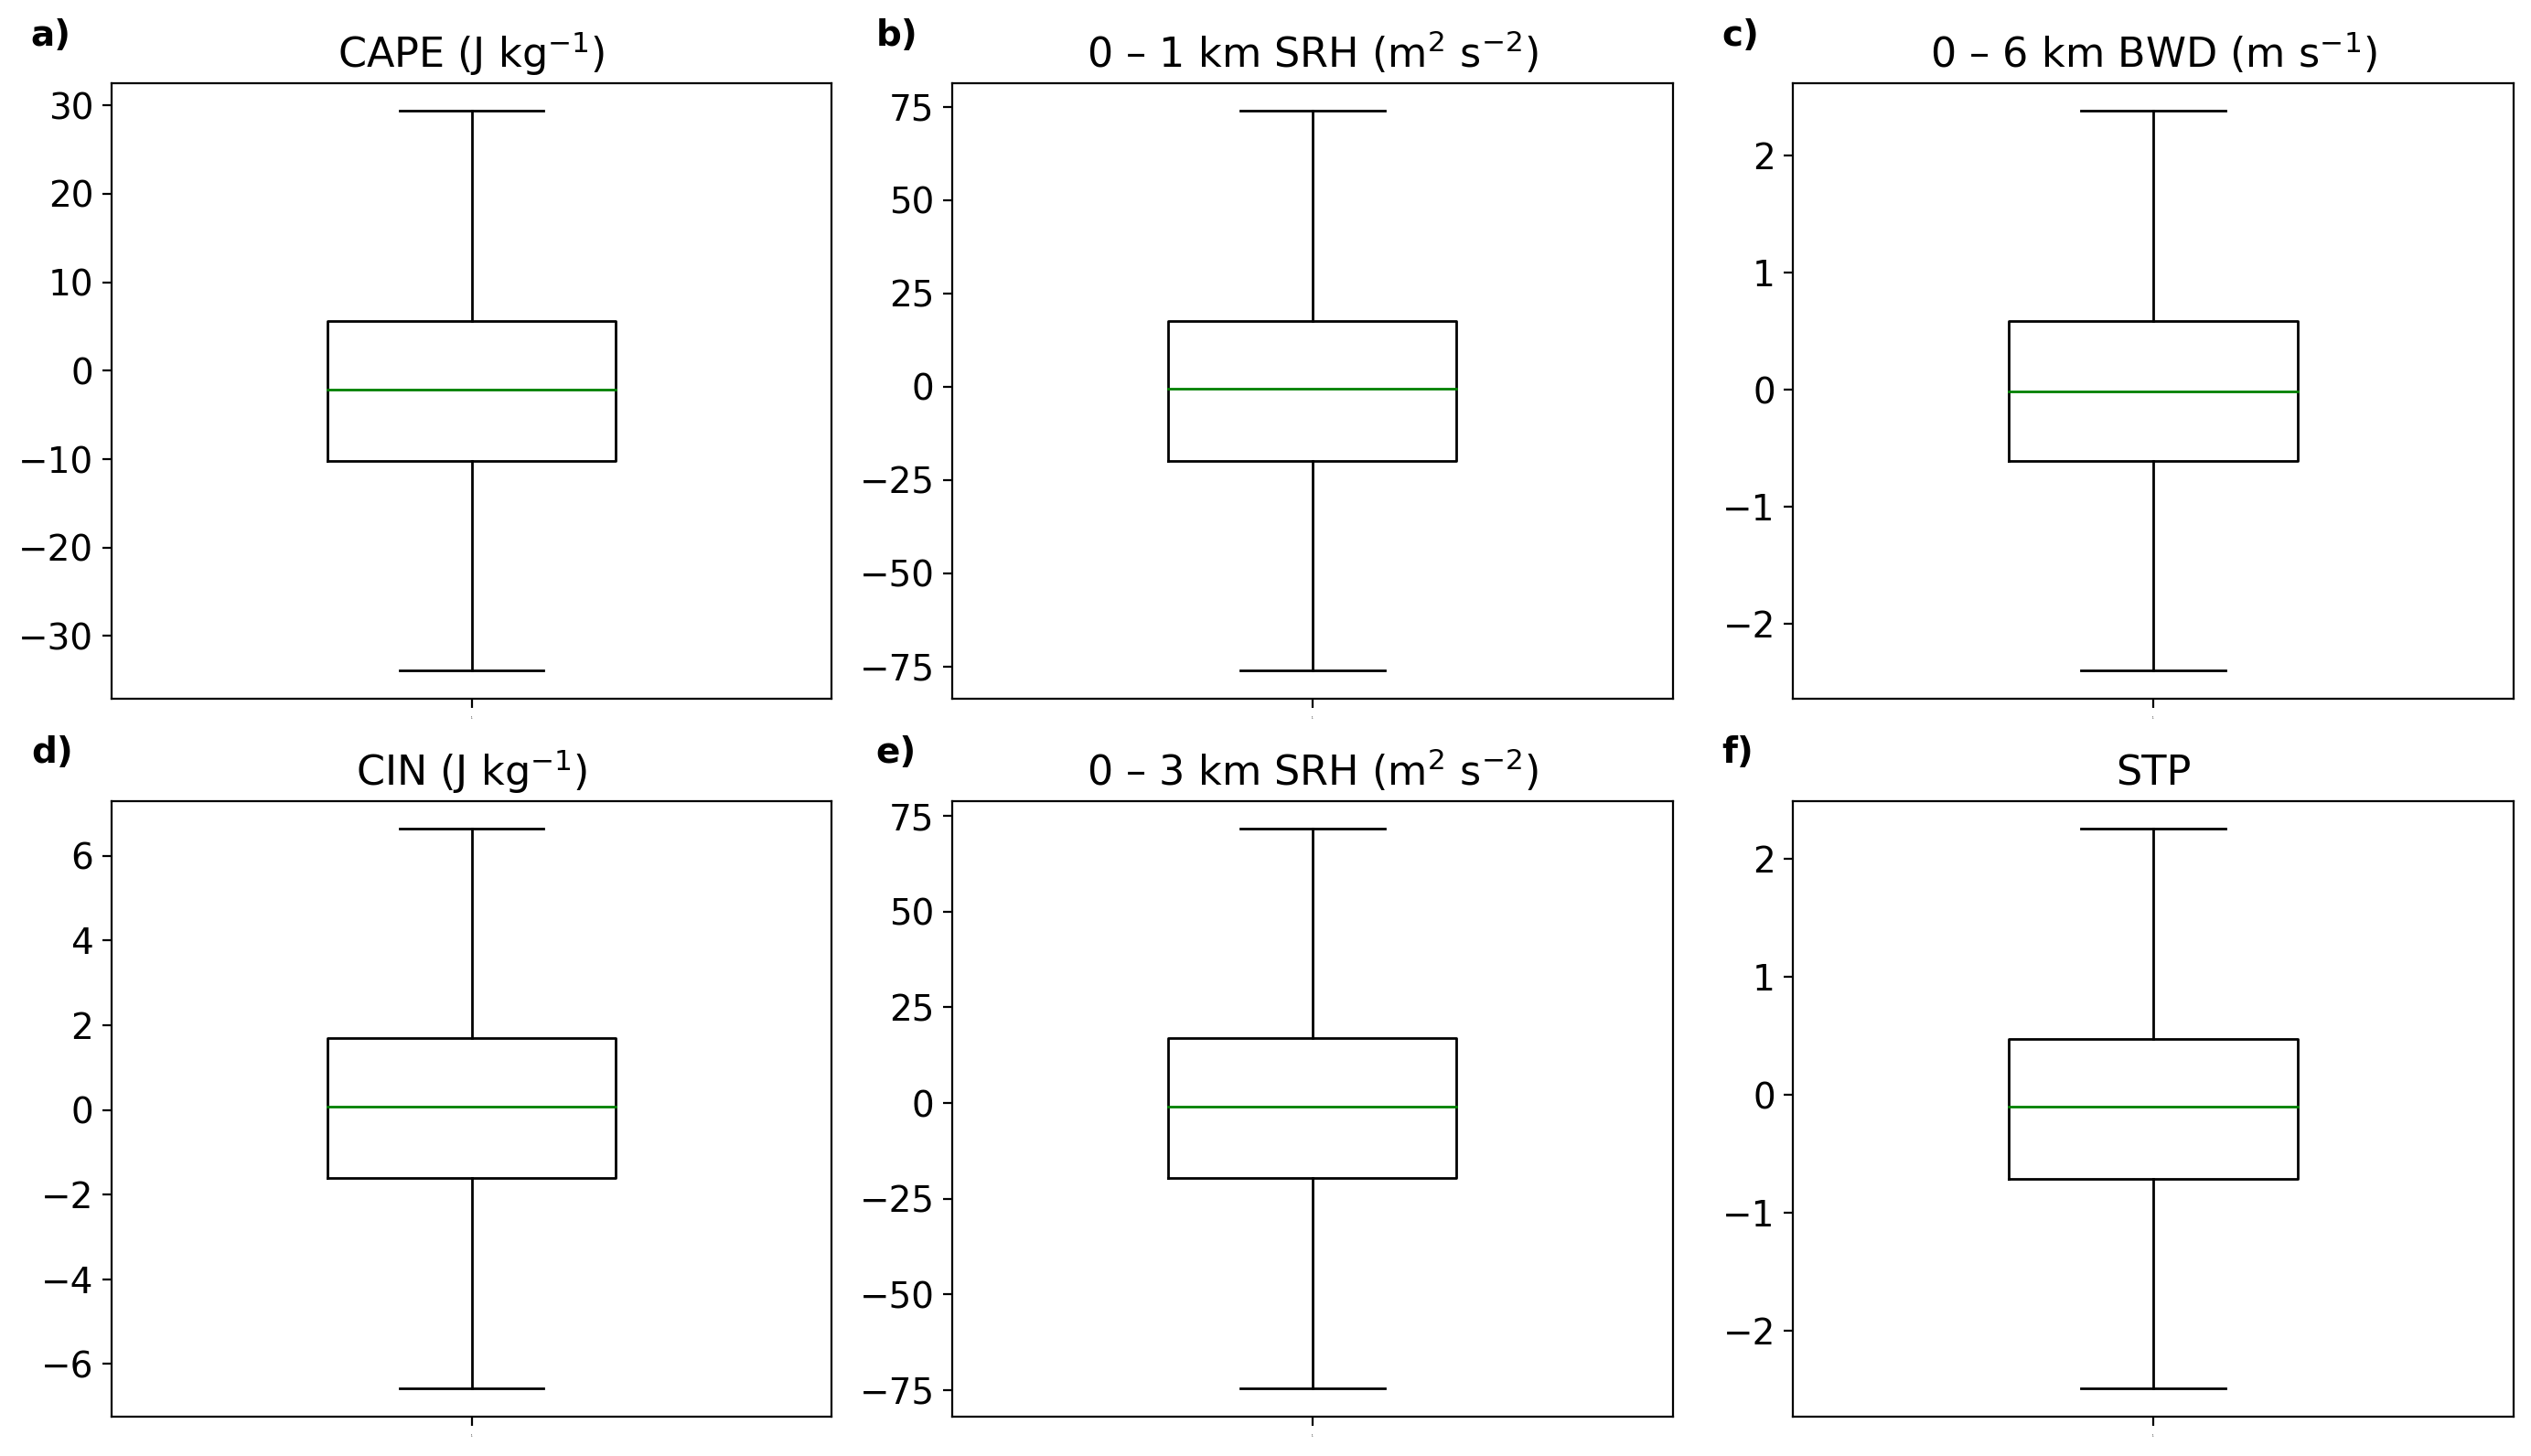

In [7]:
#Plot the Variability in The Differences Between Pseudo - Instantaneous Data Pointwise

#Create A Figure With All Boxplots without Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (14,8), dpi=200)
plt.subplots_adjust(wspace=0.05, hspace=0.2)
medianprops = dict(color='green')

#fig.suptitle('Differences in Forecasting Parameters (Pseudo - Instantaneous)')

#CAPE 
axs[0,0].boxplot([CAPE[0] - inst_CAPE[0]], 0,'',medianprops = medianprops,  widths = 0.4)
axs[0,0].set_title('CAPE (J kg$^{-1}$)', fontsize=16)
axs[0,0].tick_params(axis='y', labelsize=14)
axs[0,0].tick_params(axis='x', labelsize=0)

#CIN
axs[1,0].boxplot([CIN[0] - inst_CIN[0]], 0,'',medianprops = medianprops,  widths = 0.4)
axs[1,0].set_title('CIN (J kg$^{-1})$', fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=14)
axs[1,0].tick_params(axis='x', labelsize=0)

#SRH1km 
axs[0,1].boxplot([SRH1km - inst_SRH1km], 0,'',medianprops = medianprops,  widths = 0.4)
axs[0,1].set_title('0 – 1 km SRH (m$^2$ s$^{-2}$)', fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=14)
axs[0,1].tick_params(axis='x', labelsize=0)

#SRH3km
axs[1,1].boxplot([SRH3km - inst_SRH3km], 0,'',medianprops = medianprops,  widths = 0.4)
axs[1,1].set_title('0 – 3 km SRH (m$^2$ s$^{-2}$)', fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=14)
axs[1,1].tick_params(axis='x', labelsize=0)

#Bulk Wind Difference
axs[0,2].boxplot(BWD - inst_BWD, 0 , '',medianprops = medianprops,  widths = 0.4)
axs[0,2].set_title('0 – 6 km BWD (m s$^{-1}$)', fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=14)
axs[0,2].tick_params(axis='x', labelsize=0)

# STP
axs[1,2].boxplot(STP - inst_STP, 0 , '',medianprops = medianprops,  widths = 0.4)
axs[1,2].set_title('STP', fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=14)
axs[1,2].tick_params(axis='x', labelsize=0)
#w @ z = 7.5 m
#axs[0,2].boxplot([w[0] - inst_w[0]], 0,'')
#axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
#axs[1,2].boxplot([w[17] - inst_w[17]], 0,'')
#axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
#axs[0,3].boxplot([gr_wind - inst_gr_wind], 0,'')
#axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
#axs[1,3].boxplot([zvort[0] - inst_zvort[0]], 0,'')
#axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
#axs[0,4].boxplot([T[0] - inst_T[0]], 0,'')
#axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
#axs[1,4].boxplot([qv[0] - inst_qv[0]], 0,'')
#axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')
# Add text labels to each top right corner
fig.text(0.02, 0.97, 'a)', fontsize = 14, weight = 'demibold')
fig.text(0.35, 0.97, 'b)', fontsize = 14, weight = 'demibold')
fig.text(0.68, 0.97, 'c)', fontsize = 14, weight = 'demibold')
fig.text(0.02, 0.48, 'd)', fontsize = 14, weight = 'demibold')
fig.text(0.35, 0.48, 'e)', fontsize = 14, weight = 'demibold')
fig.text(0.68, 0.48, 'f)', fontsize = 14, weight = 'demibold')


plt.tight_layout()
plt.show()
#Save the plot
path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Figures/'
image_filename = 'diff_with_outliers.png'
fig.savefig(path + image_filename)


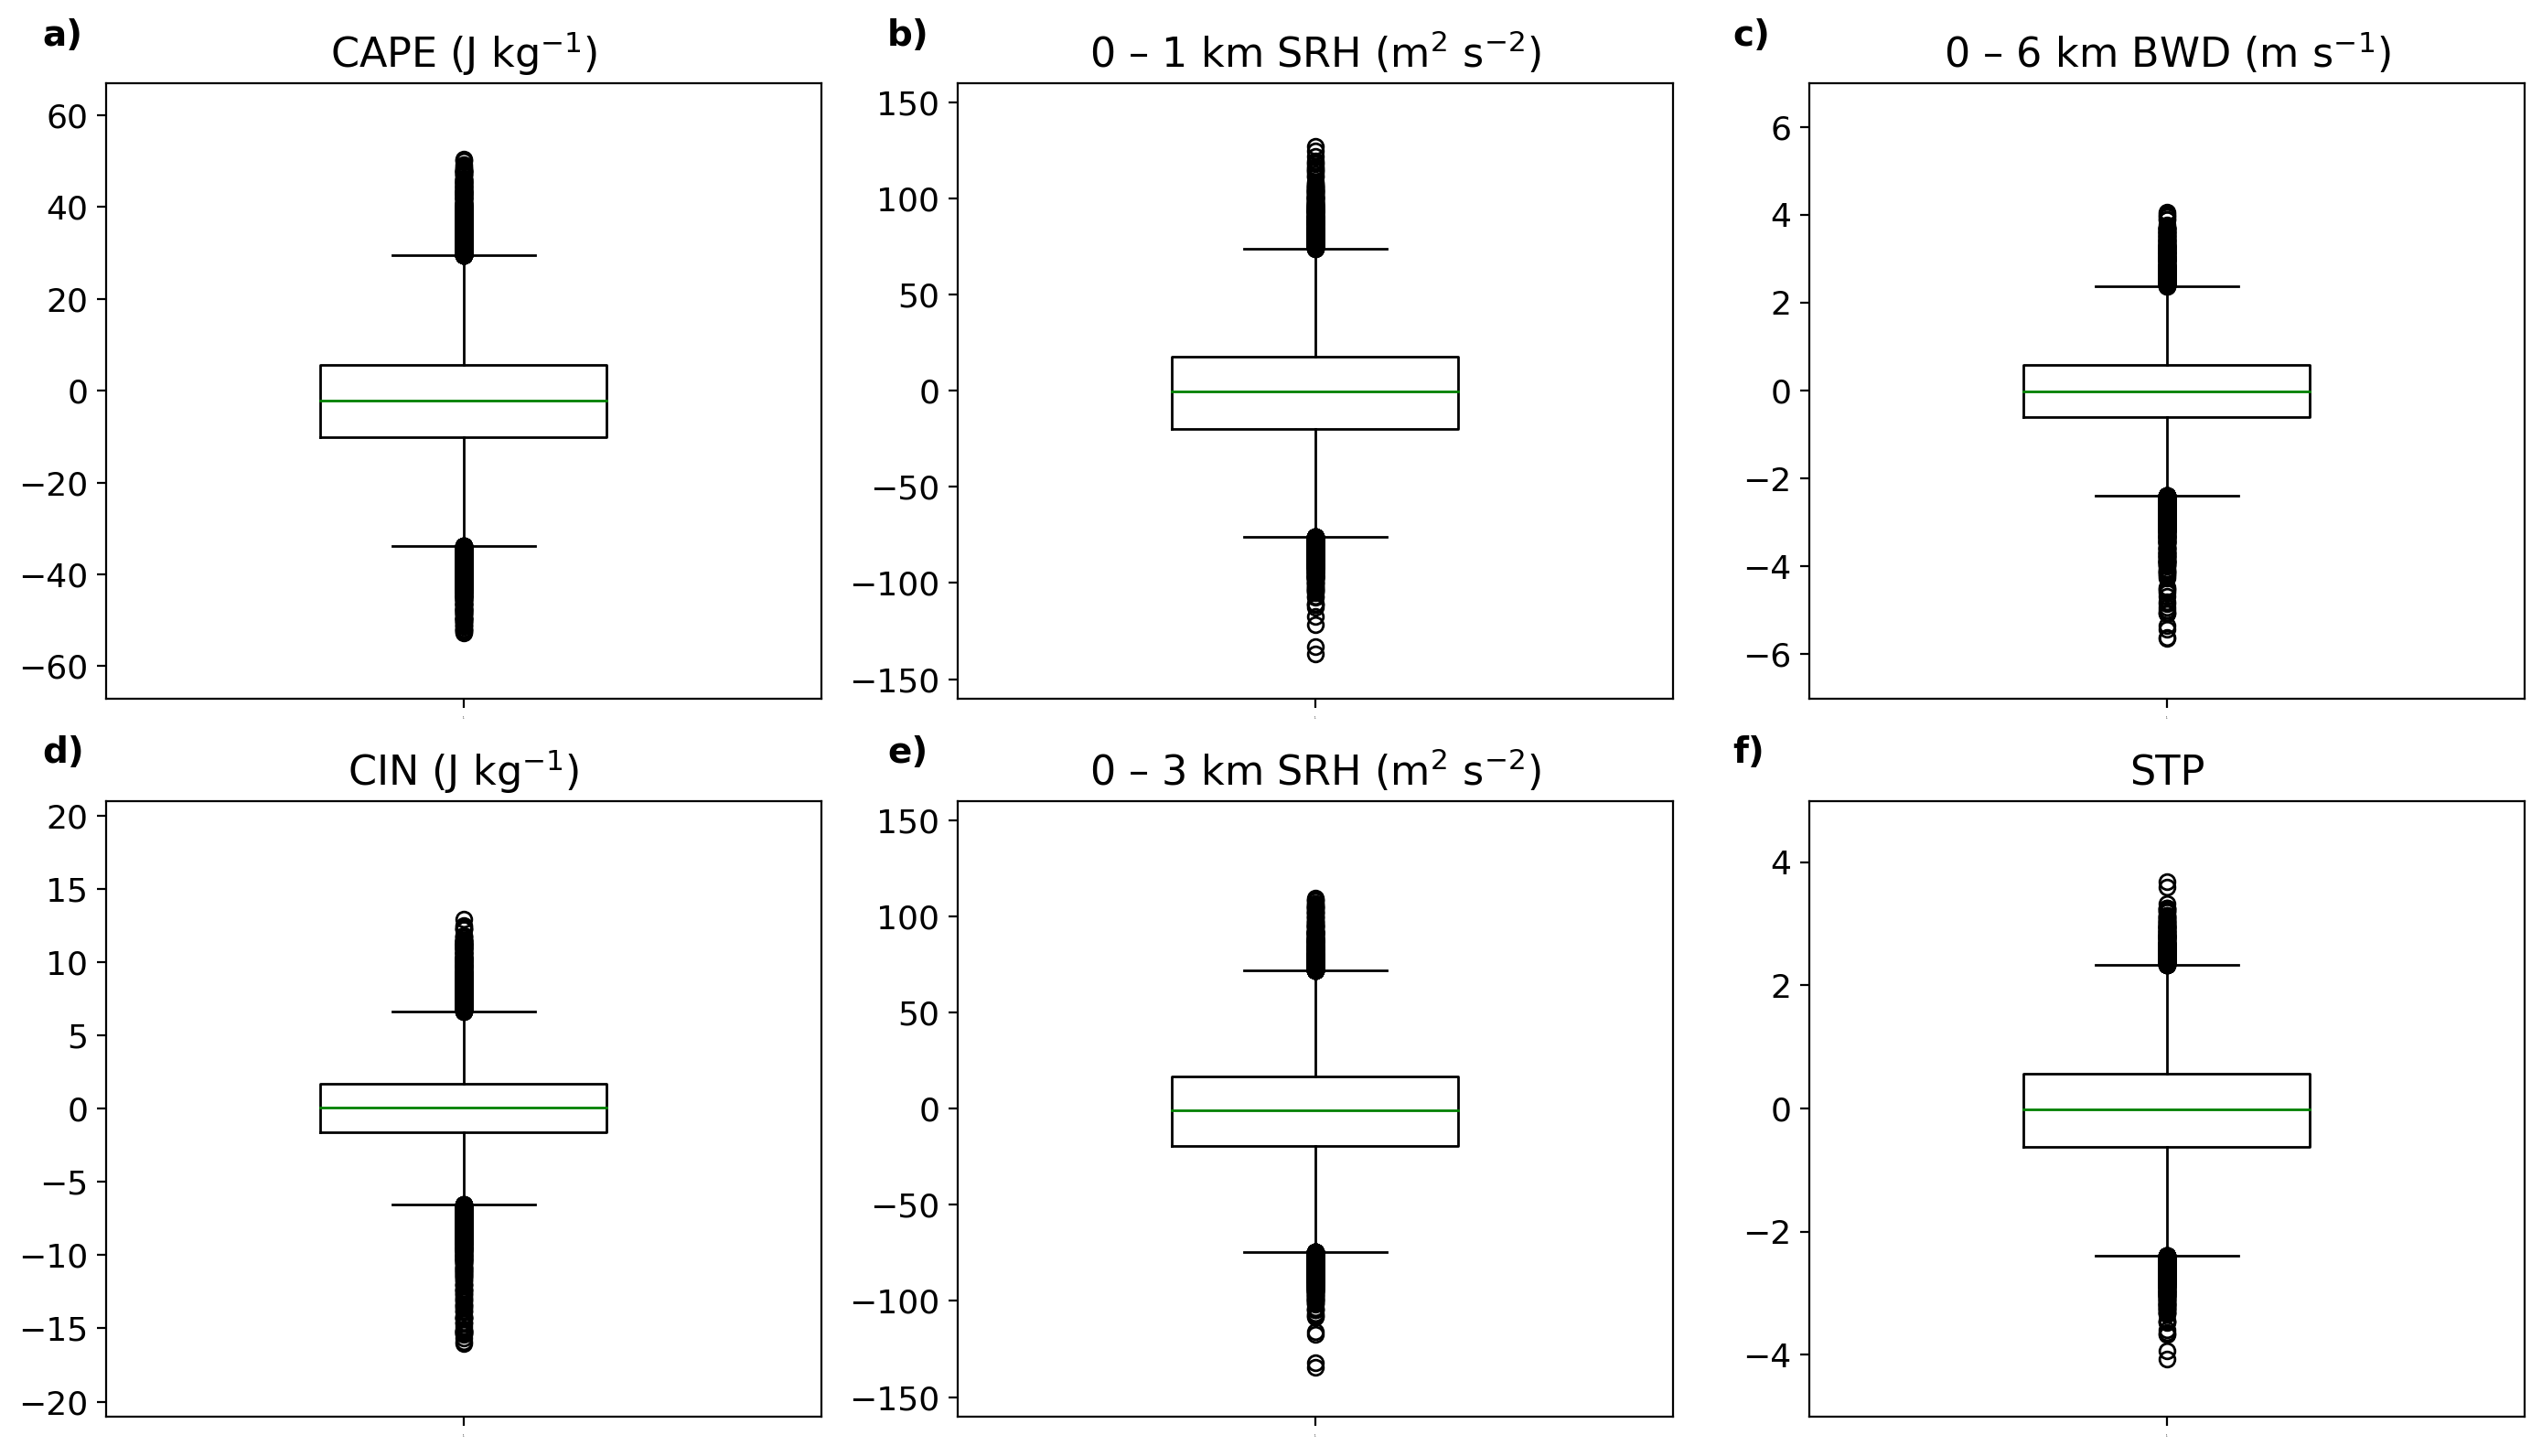

In [16]:
#Plot the Variability in The Differences Between Pseudo - Instantaneous Data Pointwise

#Create A Figure With All Boxplots with Outliers Included

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (14,8), dpi=200)
plt.subplots_adjust(wspace=0.05, hspace=0.2)
medianprops = dict(color='green')

#fig.suptitle('Differences in Forecasting Parameters (Pseudo - Instantaneous)')

#CAPE 
axs[0,0].boxplot([CAPE[0] - inst_CAPE[0]],medianprops = medianprops,  widths = 0.4)
axs[0,0].set_title('CAPE (J kg$^{-1}$)', fontsize=16)
axs[0,0].tick_params(axis='y', labelsize=13)
axs[0,0].tick_params(axis='x', labelsize=0)
axs[0,0].set_ylim(-67,67)

#CIN
axs[1,0].boxplot([CIN[0] - inst_CIN[0]],medianprops = medianprops,  widths = 0.4)
axs[1,0].set_title('CIN (J kg$^{-1})$', fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=13)
axs[1,0].tick_params(axis='x', labelsize=0)
axs[1,0].set_ylim(-21,21)

#SRH1km 
axs[0,1].boxplot([SRH1km - inst_SRH1km], medianprops = medianprops,  widths = 0.4)
axs[0,1].set_title('0 – 1 km SRH (m$^2$ s$^{-2}$)', fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=13)
axs[0,1].tick_params(axis='x', labelsize=0)
axs[0,1].set_ylim(-160,160)

#SRH3km
axs[1,1].boxplot([SRH3km - inst_SRH3km], medianprops = medianprops,  widths = 0.4)
axs[1,1].set_title('0 – 3 km SRH (m$^2$ s$^{-2}$)', fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=13)
axs[1,1].tick_params(axis='x', labelsize=0)
axs[1,1].set_ylim(-160,160)

#Bulk Wind Difference
axs[0,2].boxplot(BWD - inst_BWD, medianprops = medianprops,  widths = 0.4)
axs[0,2].set_title('0 – 6 km BWD (m s$^{-1}$)', fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=13)
axs[0,2].tick_params(axis='x', labelsize=0)
axs[0,2].set_ylim(-7,7)

# STP
axs[1,2].boxplot(STP - inst_STP,medianprops = medianprops,  widths = 0.4)
axs[1,2].set_title('STP', fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=13)
axs[1,2].tick_params(axis='x', labelsize=0)
axs[1,2].set_ylim(-5,5)
#w @ z = 7.5 m
#axs[0,2].boxplot([w[0] - inst_w[0]], 0,'')
#axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w @ z = 522 m
#axs[1,2].boxplot([w[17] - inst_w[17]], 0,'')
#axs[1,2].set_title('w @ z = 522 m (m/s)')

#Ground Relative Wind @ z = 7.5m
#axs[0,3].boxplot([gr_wind - inst_gr_wind], 0,'')
#axs[0,3].set_title('GR wind @ z = 7.5 m (m/s)')

#Vertical Vorticity @ z = 7.5 m
#axs[1,3].boxplot([zvort[0] - inst_zvort[0]], 0,'')
#axs[1,3].set_title('Vert. Vort. @ z = 7.5 m (1/s)')

#Temperature @ z = 7.5 m
#axs[0,4].boxplot([T[0] - inst_T[0]], 0,'')
#axs[0,4].set_title('Temp @ z = 7.5 m (degK)')

#WV mixing ratio @ z = 7.5 m
#axs[1,4].boxplot([qv[0] - inst_qv[0]], 0,'')
#axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')
# Add text labels to each top right corner
fig.text(0.02, 0.97, 'a)', fontsize = 14, weight = 'demibold')
fig.text(0.35, 0.97, 'b)', fontsize = 14, weight = 'demibold')
fig.text(0.68, 0.97, 'c)', fontsize = 14, weight = 'demibold')
fig.text(0.02, 0.48, 'd)', fontsize = 14, weight = 'demibold')
fig.text(0.35, 0.48, 'e)', fontsize = 14, weight = 'demibold')
fig.text(0.68, 0.48, 'f)', fontsize = 14, weight = 'demibold')


plt.tight_layout()
plt.show()
#Save the plot
path = '/storage/work/bsh5393//Masters Thesis/Pre-Storm PseudoSoundings/Figures/'
image_filename = 'diff_with_outliers.png'
fig.savefig(path + image_filename)


In [11]:
# Compute Statistics (Mean and STD)

print(f'CAPE: mean_p = {np.mean(CAPE[0])}, mean_i = {np.mean(inst_CAPE[0])}, mean diff = {np.mean(CAPE[0] - inst_CAPE[0])}, std = {np.std(CAPE[0] - inst_CAPE[0])}, min = {np.min(CAPE[0] - inst_CAPE[0])}, max = {np.max(CAPE[0] - inst_CAPE[0])}')
print(f'CIN: mean_p = {np.mean(CIN[0])}, mean_i = {np.mean(inst_CIN[0])}, mean diff = {np.mean(CIN[0] - inst_CIN[0])}, std = {np.std(CIN[0] - inst_CIN[0])}, min = {np.min(CIN[0] - inst_CIN[0])}, max = {np.max(CIN[0] - inst_CIN[0])}')
print(f'SRH1km: mean_p = {np.mean(SRH1km)}, mean_i = {np.mean(inst_SRH1km)}, mean diff = {np.mean(SRH1km-inst_SRH1km)}, std = {np.std(SRH1km-inst_SRH1km)}, min = {np.min(SRH1km-inst_SRH1km)}, max = {np.max(SRH1km-inst_SRH1km)}')
print(f'SRH3km: mean_p = {np.mean(SRH3km)}, mean_i = {np.mean(inst_SRH3km)}, mean diff = {np.mean(SRH3km - inst_SRH3km)}, std = {np.std(SRH3km - inst_SRH3km)}, min = {np.min(SRH3km - inst_SRH3km)}, max = {np.max(SRH3km - inst_SRH3km)}')
print(f'BWD: mean_p = {np.mean(BWD)}, mean_i = {np.mean(inst_BWD)},mean diff = {np.mean(BWD - inst_BWD)}, std = {np.std(BWD - inst_BWD)}, min = {np.min(BWD - inst_BWD)}, max = {np.max(BWD - inst_BWD)}')
print(f'STP: mean_p = {np.mean(STP)}, mean_i = {np.mean(inst_STP)},mean diff = {np.mean(STP-inst_STP)}, std = {np.std(STP-inst_STP)}, min = {np.min(STP-inst_STP)}, max = {np.max(STP-inst_STP)}')


CAPE: mean_p = 3676.024565340322, mean_i = 3678.3587705178393, mean diff = -2.334205177517265, std = 12.664595046578189, min = -52.79761737691524, max = 50.4614541554256
CIN: mean_p = 8.733702472633015, mean_i = 8.708154922256472, mean diff = 0.025547550376540253, std = 2.6177686854897884, min = -16.005841460680795, max = 12.939559473967956
SRH1km: mean_p = 252.0013459399486, mean_i = 253.00592456072673, mean diff = -1.004578620778074, std = 28.414573846113125, min = -137.1130783714573, max = 126.80755497081373
SRH3km: mean_p = 323.8937871639234, mean_i = 325.449449533753, mean diff = -1.5556623698295804, std = 27.645115128001976, min = -134.45109834772296, max = 109.21666644209262
BWD: mean_p = 27.74363372138968, mean_i = 27.75649036545332,mean diff = -0.01285664406364915, std = 0.9192824730378636, min = -5.630958947083254, max = 4.062482700629975
STP: mean_p = 6.442809706457892, mean_i = 6.46557828418582,mean diff = -0.02276857772792587, std = 0.8872401536720775, min = -4.08245590489

In [112]:
# Range to mean ratio
data_CAPE = CAPE[0]-inst_CAPE[0]
data_CIN = CIN[0] - inst_CIN[0]
data_SRH1km = SRH1km-inst_SRH1km
data_SRH3km = SRH3km-inst_SRH3km
data_BWD = BWD-inst_BWD
data_STP = STP-inst_STP
params = [data_CAPE, data_CIN, data_SRH1km, data_SRH3km, data_BWD, data_STP]
param_names = ['CAPE', 'CIN', 'SRH1km', 'SRH3km', 'BWD', 'STP']
for x in range(len(params)):
    data_range = (np.max(params[x]) - np.min(params[x]))/(np.mean(params[x]))
    print(f'{param_names[x]}: {data_range}')
    

CAPE: -44.23735862079206
CIN: 1133.0010317243045
SRH1km: -262.7177484006749
SRH3km: -156.63280768082652
BWD: -753.9636004329035
STP: -163.6240975176321


# Plot the Differences at Each Height Level

In [14]:
#Try to Create A BoxPlot at each height level for the differences between pseudo and instantaneous soundings for chosen variable
#Pseudo-Instantaneous


#DataFrame Dimensions
num_levels, num_data = P.shape
revised_num_levels = 27 #Only include up to about 1km above surface

# Creating the DataFrame
df = pd.DataFrame({
    'Height Level': [str(round(z_data.values[i],2)) for i in range(revised_num_levels)],
    'diff_P': [(P[i] - inst_P[i]).tolist() for i in range(revised_num_levels)],
    'diff_T': [(T[i] - inst_T[i]).tolist() for i in range(revised_num_levels)],
    'diff_Td': [(Td[i] - inst_Td[i]).tolist() for i in range(revised_num_levels)],
    'diff_Th': [(Th[i] - inst_Th[i]).tolist() for i in range(revised_num_levels)],
    'diff_qv': [(qv[i] - inst_qv[i]).tolist() for i in range(revised_num_levels)],
    'diff_u': [(u[i] - inst_u[i]).tolist() for i in range(revised_num_levels)],
    'diff_v': [(v[i] - inst_v[i]).tolist() for i in range(revised_num_levels)],
    'diff_w': [(w[i] - inst_w[i]).tolist() for i in range(revised_num_levels)],
    'diff_zvort': [(zvort[i] - inst_zvort[i]).tolist() for i in range(revised_num_levels)],
    'diff_parc_T': [(parc_T[i] - inst_parc_T[i]).tolist() for i in range(revised_num_levels)],
})

# Converting to long-form DataFrame
df_long = df.melt(id_vars=['Height Level'], var_name='Difference Type', value_name='Value')
df_long = df_long.explode('Value').reset_index(drop=True)

In [15]:
#Create and Save a BoxPlot
def boxplot(var_name):
    #Isolate The Variable
    df_diff = df_long[df_long['Difference Type'] == var_name]
    fig = plt.figure(figsize=(10, 20))  # Adjust the figure size if necessary
    sns.boxplot(x='Value', y='Height Level',data=df_diff, orient='h',fliersize = 0)
    # Set labels and title
    plt.xlabel(f'{var_name}')
    plt.ylabel('Height Level (km)')
    plt.title(f'Horizontal Boxplot for {var_name} (Pseudo-Instantaneous)')
    plt.gca().invert_yaxis()
    #Save the plot
    path = '/storage/work/bsh5393/Masters Thesis/Pre-Storm PseudoSoundings/Figures/'
    image_filename = f'{var_name}.png'
    fig.savefig(path + image_filename)
    #clear 
    plt.close()

In [16]:
#Create A Boxplot for Each Variable

for name in tqdm(df.columns[1:]):
    boxplot(name)

100%|██████████| 10/10 [00:56<00:00,  5.67s/it]
